# Introduction to Time Series


last updated: February 9, 2023 (Thanks to Constanza for the feedback)

This tutorial gives a brief introduction to analysis of time series. We provide definitions and classical models to get explorative features, trends, and learn variabilities.


### What is a time series? 

A time series $\{\boldsymbol{x}_l\}_{l=1}^L$ is an **ordered sequence of values** $\boldsymbol{x} \in \mathbb{R}^D$ indexed by $l \in \mathbb{Z}$ discrete realizations (or time steps), such that:

$\begin{equation}t_{l-1} < t_{l} < t_{l+1}\end{equation}$

where $t_{l} \in \mathbb{R}$ is the sampling time at the $l$th position. 

Notice that $\boldsymbol{x}$ could be a vector describing a realization of a random variable (observation) at some particular time step $l$.

For example, 
- The quantity of CO2 in a room (random variable) $\rightarrow X$ 
- The light capture by a telescope from a shining source in the sky $\rightarrow X$ 
- The number of vehicles passing through the toll $\rightarrow X$ 

When we work with time series, it is recommendable to **visualize data over time**. It gives us a first approach to the series properties.

There are two branches in the characterization of time series:
- **Time Domain Approach**: Lagged relationships, i.e.,  how the past and present affect the future?
- **Frequency Domain Approach**: Investigation of cycles

Let's prepare our data!

In [117]:
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")
plt.style.use('dark_background')

we will use historical copper price data in Chile 

In [118]:
cobre_df = pd.read_csv('cobre.csv', usecols=[0,1])
cobre_df.head()

Fecha  √öltimo
0  26.11.2020  3,3310
1  25.11.2020  3,3095
2  24.11.2020  3,2995
3  23.11.2020  3,2580
4  22.11.2020  3,2853

In [119]:
cobre_df['Fecha'] = cobre_df.apply(lambda x: pd.to_datetime(x['Fecha']), 1)
cobre_df['√öltimo'] = cobre_df.apply(lambda x: float(str(x['√öltimo']).replace(',', '.')), 1)
cobre_df = cobre_df.sort_values('Fecha')

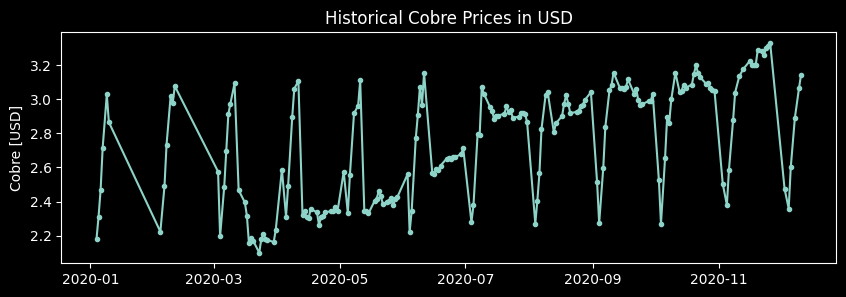

In [120]:
fig, axes = plt.subplots(1,1,figsize=(10,3))
axes.plot(cobre_df['Fecha'], cobre_df['√öltimo'], '.-')
axes.set_ylabel('Cobre [USD]')
axes.set_title('Historical Cobre Prices in USD')
plt.show()

Now is the time to describe the time series using marginal descriptive measures.

## Marginal Descriptive measure
### Mean
$\large \mu_{xt} = E(x_t) = \int_{-\infty}^{\infty} xf_t(x)dx$

In [5]:
mean = cobre_df['√öltimo'].mean()

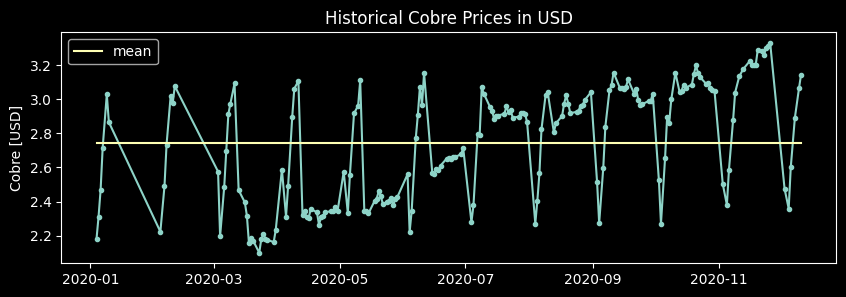

In [6]:
fig, axes = plt.subplots(1,1,figsize=(10,3))
axes.plot(cobre_df['Fecha'], cobre_df['√öltimo'], '.-')
axes.plot([cobre_df['Fecha'].min(), cobre_df['Fecha'].max()], [mean, mean], label='mean')
axes.set_ylabel('Cobre [USD]') 
axes.legend()
axes.set_title('Historical Cobre Prices in USD')
plt.show()

### The autocovariance function
Linear dependence between two point on the same serie observed at different times.

$\begin{equation}
    \large \gamma_x(s, l) = cov(x_s, x_l) = E[(x_s - \mu_x)(x_l - \mu_x)]
    \label{eq:acov}\tag{1}
\end{equation}$

Note that $\gamma_x(s, l) = \gamma_x(l, s)$ for all time $s$ and $t$

The gap between time steps $s$ and $t$ is called **lag**. For example, we can shift current copper values to create delayed sequences (i.e., DataFrame columns) associated to $lag=1,2,3,...$

In [114]:
for lag in range(1, 5):
    cobre_df[f'√öltimo_{lag}_lag'] = cobre_df['√öltimo'].shift(lag)
cobre_df.head()

Fecha  √öltimo  √öltimo_1_lag  √öltimo_2_lag  √öltimo_3_lag  √öltimo_4_lag
174 2020-01-04  2.1805           NaN           NaN           NaN           NaN
152 2020-01-05  2.3120        2.1805           NaN           NaN           NaN
130 2020-01-06  2.4705        2.3120        2.1805           NaN           NaN
108 2020-01-07  2.7170        2.4705        2.3120        2.1805           NaN
64  2020-01-09  3.0285        2.7170        2.4705        2.3120        2.1805

Rewritting Equation $(1)$ in terms of lag, 

$\begin{equation}
    \large \gamma_x(s, l) = \gamma_x(k) = cov(x_s, x_{s-k}) = E[(x_s - \mu_x)(x_{s-k} - \mu_x)] 
    \tag{2}
\end{equation}$

where $k$ is the lag and $s$ is the current value. Notice when $k=0$ (zero lag) the autocovariance function is maximum

The autocovariance function can also be written as a convolution with its time reversal ([Parseval‚Äôs theorem](http://pordlabs.ucsd.edu/sgille/sioc221a_f19/lecture7_notes.pdf)). This is particularly important since we can define autocovariance as means of the inverse fourier transform of the convolution.
$\begin{equation}
    \large \gamma_x(k) = \int_{-\infty}^{\infty} X^*X\epsilon^{i2\pi k} df
    \tag{3} = \int_{-\infty}^{\infty} x(t)x(k + t) dt
\end{equation}$
notice here $x(t)$ is a cuantinous function depending on time $t$.

Using `acovf` function we can retrieve the autocovariance function at different lags. You can use the parameter `acovf(..., fft=True)` to use Fast Furier Transform (FFT) when calculating the autocovariance. [As the official documentation says](https://www.statsmodels.org/dev/_modules/statsmodels/tsa/stattools.html#acf) this method should be preferred for long time series.

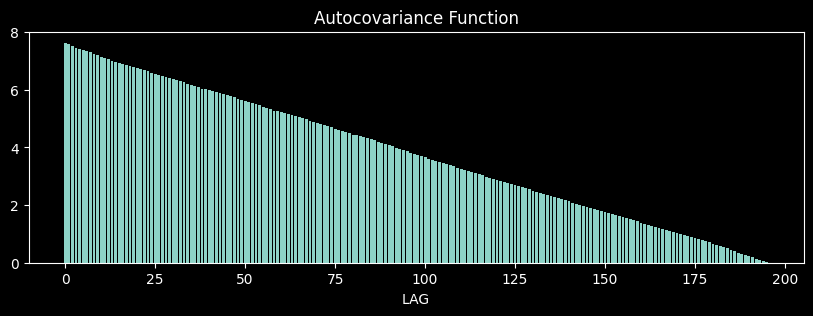

In [122]:
acov = smt.stattools.acovf(cobre_df['√öltimo'], 
                           adjusted=False, # denominators is n-k, otherwise n
                           demean=False, # subtract the mean x from each element of x
                           missing="none", # how the NaNs are to be treated.
                           fft=True, # if use FFT to compute autocovariance
                           nlag=cobre_df['√öltimo'].shape[0]-1 # Limit the number of autocovariances returned.
                          )
plt.figure(figsize=(10,3))
plt.bar(range(len(acov)), acov)
plt.title('Autocovariance Function')
plt.xlabel('LAG')
plt.show()

### Autocorrelation Function (ACF)
The ACF measures the linear predictability of the series at time $l$, say $x_l$ using only
the value $x_s$.

$\large \rho (s, t) = \frac{\gamma_{x}(s, l)}{\sqrt{\gamma(s,s)_{x}\gamma_{x}(l,l)}}$

for stationary stochastic process,

$\large \rho (s, t) = \frac{\gamma_{x}(s, l)}{\sigma^2}$

Finally, for **regular** time series i.e., $\Delta t_l = \Delta t_s \forall (l,s) \in \mathbb{Z}\times\mathbb{Z}$ where $\Delta l = t_l - t_{l-1}$ and $\Delta s = t_s - t_{s-1}$

$\large \rho(k) = \frac{\sum_{l = k+1}^L (x_l - \bar{x})(x_{l-k} - \bar{x})}{\sum_{l=1}^L (x_l - \bar{x})^2}$

**Going back to the code...**
As we have seen in the previous equations, the autocorrelation function depends on the autocovariance, so then we can easily calculate the autocorrelation values for our input, 

The first step is to get the `acf` the autocovariance function

In [140]:
avf = smt.acovf(cobre_df['√öltimo'], 
                adjusted=False, 
                demean=True, # here we subtract the mean 
                fft=True,
                missing="none")

then we select the number of lags we want to get, and normalice with $\sigma^2$

In [141]:
nlags = cobre_df.shape[0]
acf = avf[: nlags + 1] / avf[0] # the first element correspond to the cov(x_i, x_i) = var(x_i)

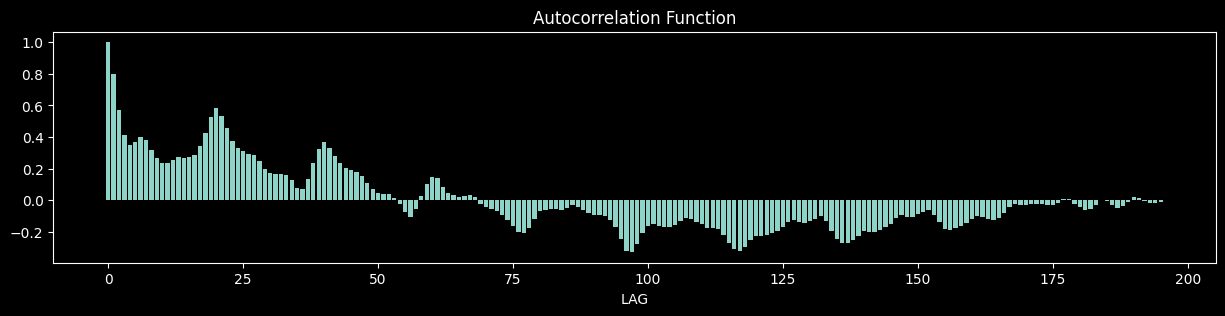

In [142]:
plt.figure(figsize=(15,3))
plt.bar(range(len(acf)), acf)
plt.title('Autocorrelation Function')
plt.xlabel('LAG')
plt.show()

You can also use `stattools.acf` that calculate the autocorrelation function [in a similar way](https://www.statsmodels.org/dev/_modules/statsmodels/tsa/stattools.html#acf)

In [145]:
acf_library = stattools.acf(cobre_df['√öltimo'],
                            fft=True,nlags=196)
(acf_library == acf).all()

True

you can also use `matplotlib` for visualizing autocorrelation.

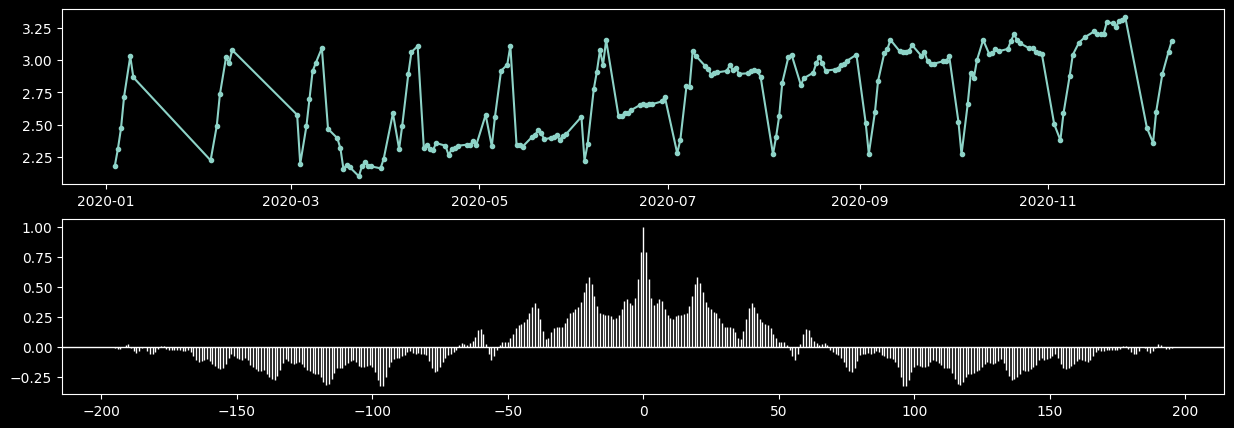

In [147]:
fig, axes = plt.subplots(2, 1, figsize=(15,5))

axes[0].plot(cobre_df['Fecha'], cobre_df['√öltimo'], '.-')

values_zero_mean = cobre_df['√öltimo'] - cobre_df['√öltimo'].mean()
axes[1].acorr(values_zero_mean, usevlines=True, normed=True, maxlags=195, lw=1)
plt.show()

## Partial Autocorrelation

Autocorrelation without indirect correlations

In [12]:
from statsmodels.graphics.tsaplots import plot_pacf

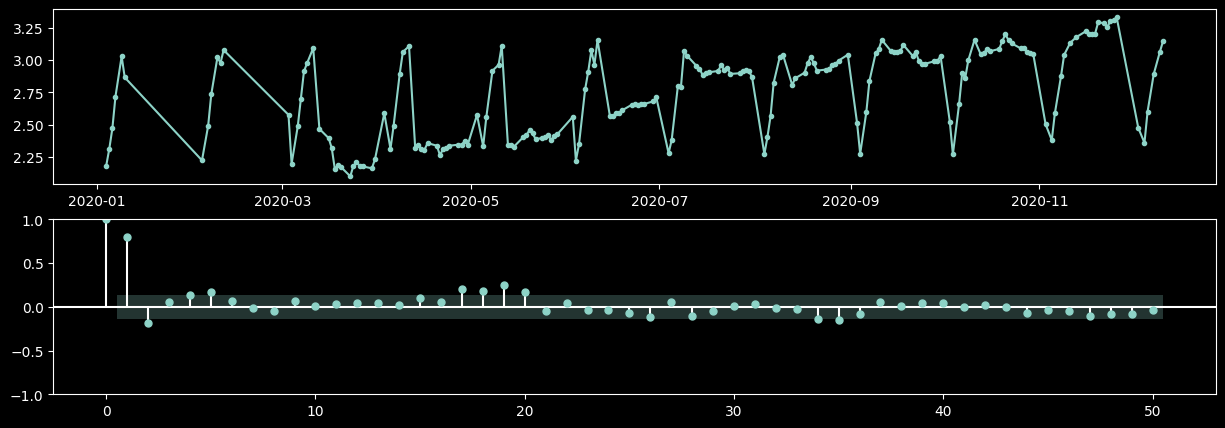

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(15,5))

axes[0].plot(cobre_df['Fecha'], cobre_df['√öltimo'], '.-')
plot_pacf(cobre_df['√öltimo'], lags=50, ax=axes[1],title='')
plt.show()



## Studying Time Series Behavior

So far we have seen general descriptors. However, we did not introduce assumptions about the behavior of the sequence. 

## Stationarity


### Strictly Stationary

The behavior of $\{ x_{t_1}, x_{t_2}, x_{t_3}\}$ should be identical of $\{ x_{t_1 + h}, x_{t_2 + h}, x_{t_3+ h}\}$. In other words 

$P(x_{t_1}\leq c_1, ..., x_{t_l}\leq c_l) \equiv P(x_{t_1+h}\leq c_1, ..., x_{t_l + h}\leq c_l)$

for all steps $l \in \mathbb{Z}$ indexing $t \in \mathbb{R}$

$\mu = \mu_l = \mu_{s}$ being $s \neq l$

Similarly, the autocovariance function,

$\gamma(s, l) = \gamma(s+h, l+h)$

Intuitively, we say the result of the autocovariance of the process depends only on the time difference between ùë† and ùëô and not on the actual times.

### Weakly Stationary
**Strictly stationary** the joint probability of a given shifted subset concerning the other should be the same.

**Weakly Stationary** concerns the shift-time-invariance of **first** and **second moments** of a process

In general, we refer to weak stationarity when we say stationarity.

## Trend Techniques
### Moving Average Smooting

$\hat{T}_l = \frac{1}{m} \sum_{j=-k}^k x_{l+j}$ where $m = 2k +1$

In [14]:
def MovingAverageSmoothing(serie, k=3):
    steps  = len(serie)
    trends = []
    m = 2*k + 1
    for j in range(k, steps-k):
        t = np.sum(serie[j-k:j+k])*(1/m)
        trends.append(t)
    return np.array(trends)

In [15]:
k = 5
trend_cobre = MovingAverageSmoothing(cobre_df['√öltimo'], k=k)
times_trend = cobre_df['Fecha'][k:-k]

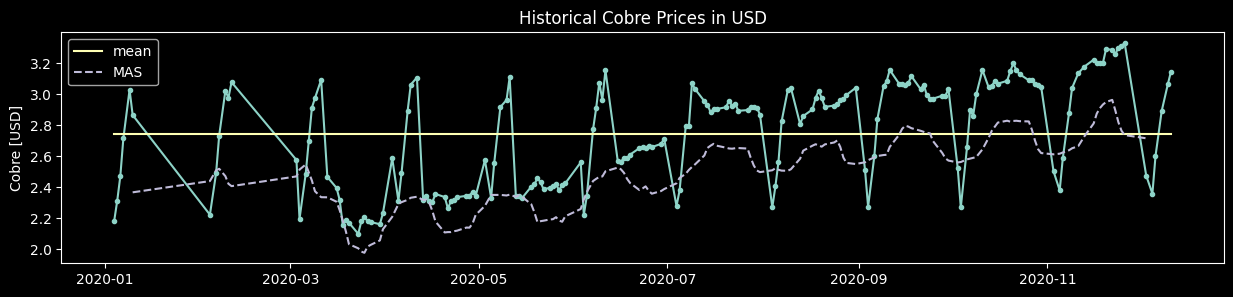

In [16]:
fig, axes = plt.subplots(1,1,figsize=(15,3))
axes.plot(cobre_df['Fecha'], cobre_df['√öltimo'], '.-')
axes.plot([cobre_df['Fecha'].min(), cobre_df['Fecha'].max()], [mean, mean], label='mean')
axes.plot(times_trend, trend_cobre, '--', label='MAS')
axes.set_ylabel('Cobre [USD]') 
axes.legend()
axes.set_title('Historical Cobre Prices in USD')
plt.show()

### Simple Exponential Smoothing

$x_{l+1} = \alpha x_l + \alpha(1 - \alpha)x_{l-1} + \alpha(1-\alpha)^2x_{l-2}...$

In [17]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [18]:
data = cobre_df
model_no_fitted = SimpleExpSmoothing(cobre_df['√öltimo']).fit(smoothing_level=0.2,
                                                             optimized=False)
model_fitted = SimpleExpSmoothing(cobre_df['√öltimo']).fit()

/home/ippo/miniconda3/envs/moons/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ippo/miniconda3/envs/moons/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


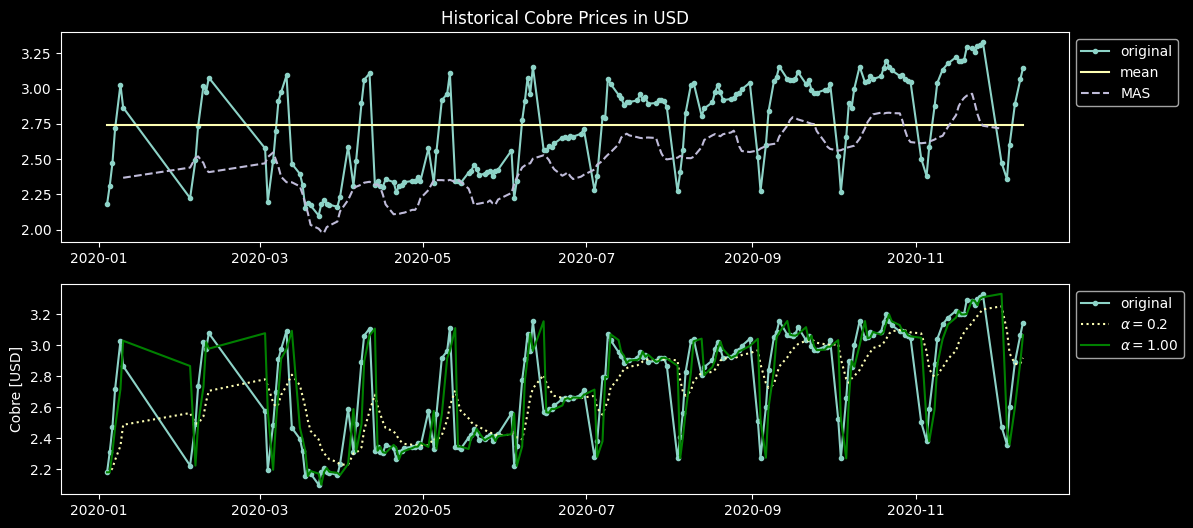

In [19]:
fig, axes = plt.subplots(2,1,figsize=(13,6))

axes[0].plot(cobre_df['Fecha'], cobre_df['√öltimo'], '.-', label='original')
axes[0].plot([cobre_df['Fecha'].min(), cobre_df['Fecha'].max()], [mean, mean], label='mean')
axes[0].plot(times_trend, trend_cobre, '--', label='MAS')
axes[0].legend(bbox_to_anchor=(1,1))

axes[1].plot(cobre_df['Fecha'], cobre_df['√öltimo'], '.-', label='original')
axes[1].plot(cobre_df['Fecha'], model_no_fitted.fittedvalues, ':', label=r'$\alpha=0.2$')
axes[1].plot(cobre_df['Fecha'], model_fitted.fittedvalues, '-', 
             label=r'$\alpha={:.2f}$'.format(model_fitted.params['smoothing_level']), 
             color='g')

axes[1].set_ylabel('Cobre [USD]') 
axes[1].legend(bbox_to_anchor=(1,1))
axes[0].set_title('Historical Cobre Prices in USD')
plt.show()

## Autoregressive Processes

An Autoregressive Process **generalize the idea of regression** to mimic the **linear dependence** between a dependent variable $x_t$ and its past $x_{t-1}$, such that:

$\begin{equation}x_t = c + bx_{t-1} + \epsilon_t\end{equation}$

where $\epsilon_t \sim \mathcal{N}(0, \sigma^2)$ $i.i.d$ is the gaussian **error of the process** and $t \in \mathbb{Z}_+$ is an **index variable** representing the step within the serie.

We can also extend the formula above to generalize over more than 1 step back (**lags**), let's say:

$\begin{equation}x_t = c + bx_{t-1}+ b'x_{t-2}+ b''x_{t-3} + \epsilon_t\end{equation}$

A serie $\{x_i\}_{t=1}^T$ follows **first order autoregressive process (AR(1))** if 

$\begin{equation}x_t = c + \phi x_{t-1} + \epsilon_t\end{equation}$

where:
- $c$ is a constant
- $\phi$ is a constant and it is constrained to $-1<\phi<1$ to force the process to be **stationary**
- $\epsilon_t \sim \mathcal{N}(0, \sigma^2)$ $i.i.d$ is called *innovations*

Since the process is stationary, then $E[x_t] = E[x_{t-1}] = \mu = \frac{c}{1-\phi}$ [(proof)](./stationarity.pdf)

By reeplacing $c$ in the AR(1) we obtain the most used AR(1)

$x_{t} = \phi x_{t-1} + \epsilon_t$

where $\phi^k$ is also the **autocorrelation** of order $k$

In [20]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller

In [21]:
x = cobre_df['√öltimo'].values

In [23]:
stationary_test = adfuller(x, autolag='AIC')

(-5.2630484756502875,
 6.52793954806609e-06,
 1,
 194,
 {'1%': -3.4645146202692527,
  '5%': -2.8765564361715534,
  '10%': -2.5747745328940375},
 -90.55069254317135)

In [23]:
print('p value: {:.2e}'.format(stationary_test[1]))

p value: 6.53e-06


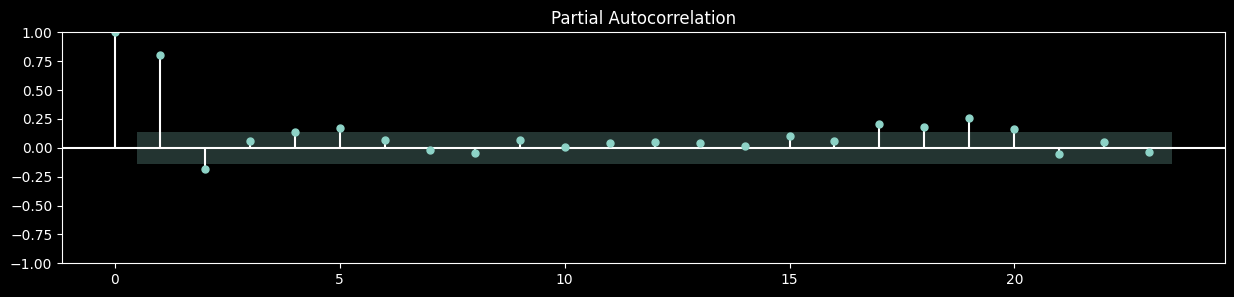

In [24]:
fig, axes = plt.subplots(1,1, figsize=(15,3))
plot_pacf(x, lags=None, ax=axes,title='Partial Autocorrelation')
plt.show()

by seeing the PACF we can define our **autoregressive lags**.

Now let's we split the serie in **training** and **testing** subset

In [25]:
cobre_df['Fecha'].shape

(196,)

In [26]:
t_train, t_test = cobre_df['Fecha'][:150], cobre_df['Fecha'][150:]
x_train, x_test = x[:150], x[150:]

In [27]:
ar_model = AutoReg(x_train, lags=20)
ar_model = ar_model.fit()

In [28]:
ar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                  150
Model:                    AutoReg(20)   Log Likelihood                  58.087
Method:               Conditional MLE   S.D. of innovations              0.155
Date:                Thu, 09 Feb 2023   AIC                            -72.173
Time:                        15:18:58   BIC                             -9.088
Sample:                            20   HQIC                           -46.540
                                  150                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.196      0.020      0.984      -0.380       0.388
y.L1           0.7443      0.085      8.756      0.000       0.578       0.911
y.L2          -0.0407      0.103     -0.395      0.693      -0.243       0.161
y.L3          -0.0409      0.103     -0.398      0.690      -0.242       0.160
y.L4          -0.0532      0.103     -0.518      0.604      -0.254       0.148
y.L5           0.1825      0.102      1.789      0.074      -0.017       0.383
y.L6          -0.1255      0.103     -1.220      0.223      -0.327       0.076
y.L7           0.0921      0.102      0.906      0.365      -0.107       0.291
y.L8          -0.0426      0.102     -0.418      0.676      -0.242       0.157
y.L9           0.0580      0.101      0.577      0.564      -0.139       0.255
y.L10         -0.0435      0.100     -0.434      0.664      -0.240       0.153
y.L11          0.0471      0.100      0.471      0.638      -0.149       0.243
y.L12         -0.0219      0.100     -0.219      0.827      -0.218       0.174
y.L13         -0.0668      0.099     -0.676      0.499      -0.261       0.127
y.L14         -0.0260      0.095     -0.273      0.785      -0.213       0.161
y.L15          0.1314      0.094      1.395      0.163      -0.053       0.316
y.L16         -0.1173      0.094     -1.245      0.213      -0.302       0.067
y.L17         -0.0197      0.095     -0.207      0.836      -0.206       0.167
y.L18          0.1131      0.095      1.185      0.236      -0.074       0.300
y.L19          0.1332      0.097      1.378      0.168      -0.056       0.323
y.L20          0.1000      0.080      1.253      0.210      -0.056       0.257
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             0.9994           -0.0000j            0.9994           -0.0000
AR.2             0.9768           -0.2892j            1.0187           -0.0458
AR.3             0.9768           +0.2892j            1.0187            0.0458
AR.4             0.8354           -0.6022j            1.0298           -0.0994
AR.5             0.8354           +0.6022j            1.0298            0.0994
AR.6             0.6263           -0.8530j            1.0582           -0.1492
AR.7             0.6263           +0.8530j            1.0582            0.1492
AR.8             0.3266           -1.0079j            1.0595           -0.2001
AR.9             0.3266           +1.0079j            1.0595            0.2001
AR.10           -0.0647           -1.0867j            1.0886           -0.2595
AR.11           -0.0647           +1.0867j            1.0886            0.2595
AR.12           -0.9065           -0.6501j            1.1155           -0.4010
AR.13           -0.9065           +0.6501j            1.1155            0.4010
AR

In [29]:
x_pred_ar = ar_model.predict(start=len(x_train), end=len(x)-1)

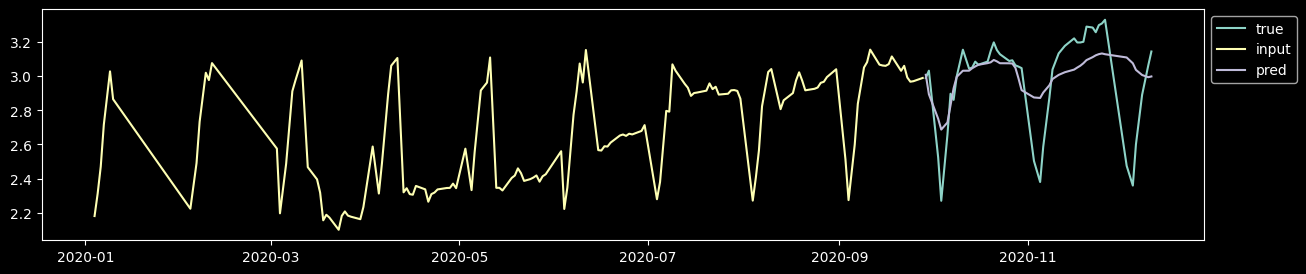

In [30]:
fig, axes = plt.subplots(1,1, figsize=(15,3))
axes.plot(t_test, x_test, label='true')
axes.plot(t_train, x_train, label='input')
axes.plot(t_test, x_pred_ar, label='pred')
axes.legend(bbox_to_anchor=(1,1))
plt.show()

In [31]:
from sklearn.metrics import mean_squared_error
print('RMSE: {:.2f}'.format(mean_squared_error(x_test, x_pred_ar)))

RMSE: 0.05


## The First Order Moving Average MA(1)

The AR is relatively a good model for modeling **long-term dependencies**. Basically we predict the next point based on all previous observations.

When the current value is only correlated with a small number of previous values, the AR is not good enough.

**Moving Average** is a family of processes that have *very short memory*

It is defined by 
$\begin{equation}
\bar{x}_t = \epsilon_{t} + \phi_1 \epsilon_{t-1}
\end{equation}$

where $\bar{x}_t = x_t - \mu$ and $\epsilon$ is an error term ($i.i.d \sim \mathcal{N}(0, \sigma^2)$) defining the change in a particular time


with, 
- $E[x_t]=E[\epsilon_{t} - \phi_1 \epsilon_{t-1}] = 0 $
- $Var[x_t]= Var(\epsilon_{t} - \phi_1 \epsilon_{t-1}) =\sigma^2(1+\theta^2_1)$
- $\rho_1 = \dfrac{\theta_1}{1+\theta^2_1}, \text{ and } \rho_h = 0 \text{ for } h \ge 2$

Generalizing to more than 1 order:

$\begin{equation}
x_t = \epsilon_{t} - \phi_1 \epsilon_{t-1} - \phi_2 \epsilon_{t-2} -...- \phi_k \epsilon_{t-k}
\end{equation}$

where $k$ is the maximum lag.

## Autoregresive Moving Average (ARMA)

It is the combination of an autoregressive model of lag $k_{ar}$ and a moving average model of lag $k_{ma}$

$\text{ARMA}(k_{ar}, k_{ma}) = \text{AR}(k_{ar}) + \text{MA}(k_{ma})$


In [32]:
from statsmodels.tsa.arima.model import ARIMA

In [33]:
%%time
arma_model = ARIMA(x_train, order=(20, 0, 2))
arma_model = arma_model.fit()

CPU times: user 2.04 s, sys: 14.7 ms, total: 2.05 s
Wall time: 1.37 s


/home/ippo/miniconda3/envs/moons/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [34]:
x_pred_arma = arma_model.predict(len(x_train), len(x)-1)

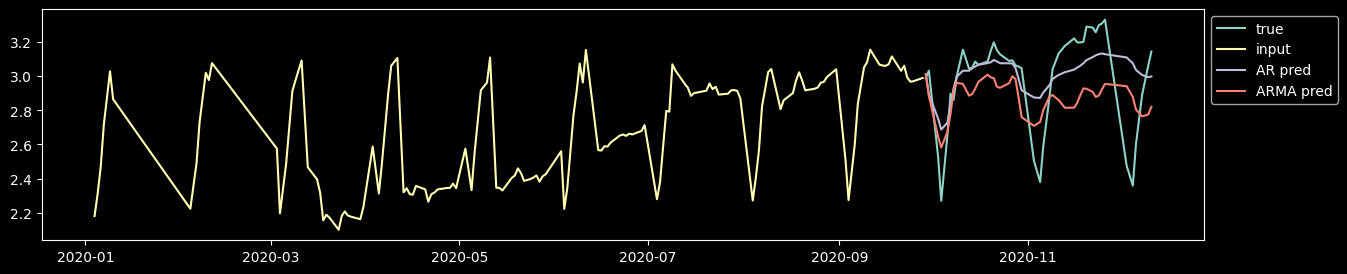

In [35]:
fig, axes = plt.subplots(1,1, figsize=(15,3))
axes.plot(t_test, x_test, label='true')
axes.plot(t_train, x_train, label='input')
axes.plot(t_test, x_pred_ar, label='AR pred')
axes.plot(t_test, x_pred_arma, label='ARMA pred')
axes.legend(bbox_to_anchor=(1,1))
plt.show()

## Autoregressive Integrated Moving Average (ARIMA)

It is like an ARMA model, but in this case, we add a new $d$ hyperparameter, which **differentiates** the input variable until **we success stationarity**.

We use ARIMA models in cases where the series **appear to be stationary** except for the moving mean. 

### What does differentiation means?

**Differentiation** is the process by which a series is transformed into its differences:

$\begin{equation}z_t = x_{t+1} - x_t ,\ \ \forall t\in T \end{equation}$

In [36]:
first_d = np.diff(x_train) # First differentiation
second_d = np.diff(first_d) # Second differentiation

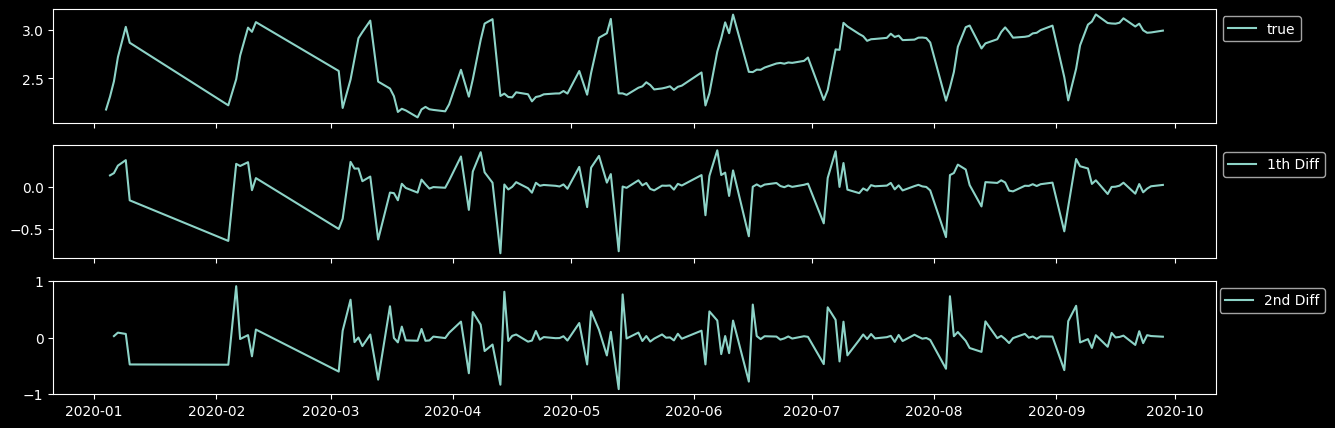

In [37]:
fig, axes = plt.subplots(3,1, figsize=(15,5), sharex=True)
axes[0].plot(t_train, x_train, label='true')
axes[0].legend(bbox_to_anchor=(1,1))
axes[1].plot(t_train[1:], first_d, label='1th Diff')
axes[1].legend(bbox_to_anchor=(1.1,1))
axes[2].plot(t_train[2:], second_d, label='2nd Diff')
axes[2].legend(bbox_to_anchor=(1.1,1))

ARIMA tries to predict not only on the original series but also its $d$ differentiations. 

In [38]:
from statsmodels.tsa.arima.model import ARIMA

In [39]:
arima_model = ARIMA(x_train, order=(20,1,1))
arima_model = arima_model.fit()

/home/ippo/miniconda3/envs/moons/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [40]:
x_pred_arima = arima_model.forecast(steps=len(t_test))

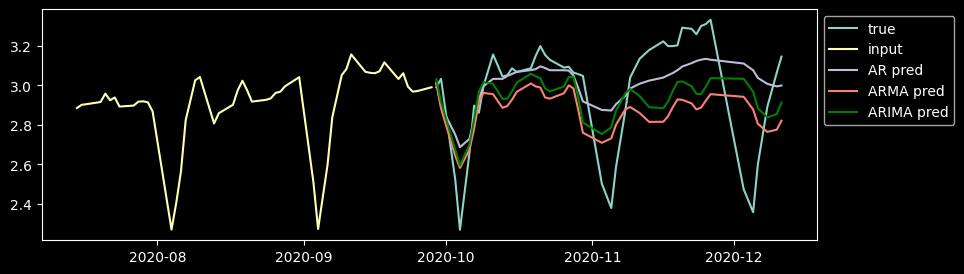

In [41]:
fig, axes = plt.subplots(1,1, figsize=(10,3))
axes.plot(t_test, x_test, label='true')
axes.plot(t_train[100:], x_train[100:], label='input')
axes.plot(t_test, x_pred_ar, label='AR pred')
axes.plot(t_test, x_pred_arma, label='ARMA pred')
axes.plot(t_test, x_pred_arima, label='ARIMA pred', color='green')
axes.legend(bbox_to_anchor=(1,1))
plt.show()

In [42]:
print('AR: {:.3f}\nARMA: {:.3f}\nARIMA: {:.3f}'.format(mean_squared_error(x_test, x_pred_ar),
                                               mean_squared_error(x_test, x_pred_arma),
                                               mean_squared_error(x_test, x_pred_arima)))

AR: 0.049
ARMA: 0.067
ARIMA: 0.055


In [43]:
import itertools
import multiprocessing
from joblib import Parallel, delayed

In [44]:
p = range(15, 20)
d = range(0, 3)
q = range(0, 10)
pdq = list(itertools.product(p,d,q))

In [45]:
%%time
def train_step(conf):
    try:
        model = ARIMA(x_train, order=conf)
        model = model.fit()
        return model
    except:
        return None


num_cores = multiprocessing.cpu_count()
response = Parallel(n_jobs=num_cores)(delayed(train_step)(conf) for conf in pdq)

CPU times: user 2.14 s, sys: 1.94 s, total: 4.08 s
Wall time: 1min 22s


In [46]:
aic_list = [(m.bic, m) for m in response if m is not None]
aic_list = sorted(aic_list, key=lambda tup: tup[0])

best_arima = aic_list[0][-1]
best_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  150
Model:                ARIMA(16, 1, 2)   Log Likelihood                  52.281
Date:                Thu, 09 Feb 2023   AIC                            -66.562
Time:                        15:20:24   BIC                             -9.487
Sample:                             0   HQIC                           -43.374
                                - 150                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9541      0.213      4.479      0.000       0.537       1.372
ar.L2         -0.5994      0.199     -3.015      0.003      -0.989      -0.210
ar.L3         -0.0793      0.151     -0.526      0.599      -0.375       0.217
ar.L4         -0.1600      0.173     -0.923      0.356      -0.500       0.180
ar.L5          0.0091      0.161      0.057      0.955      -0.307       0.325
ar.L6         -0.1489      0.139     -1.069      0.285      -0.422       0.124
ar.L7          0.0689      0.155      0.445      0.656      -0.234       0.372
ar.L8         -0.3115      0.179     -1.740      0.082      -0.662       0.039
ar.L9          0.0808      0.210      0.385      0.700      -0.330       0.491
ar.L10        -0.1591      0.217     -0.732      0.464      -0.585       0.267
ar.L11        -0.0202      0.217     -0.093      0.926      -0.446       0.406
ar.L12        -0.1514      0.173     -0.873      0.382      -0.491       0.188
ar.L13        -0.0036      0.150     -0.024      0.981      -0.298       0.291
ar.L14        -0.1664      0.140     -1.187      0.235      -0.441       0.108
ar.L15         0.0419      0.127      0.331      0.741      -0.206       0.290
ar.L16        -0.2779      0.110     -2.521      0.012      -0.494      -0.062
ma.L1         -1.2083      0.207     -5.846      0.000      -1.613      -0.803
ma.L2          0.5520      0.195      2.824      0.005       0.169       0.935
sigma2         0.0281      0.003      8.252      0.000       0.021       0.035
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                52.68
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.36   Skew:                            -0.95
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [47]:
x_pred_arima = best_arima.forecast(steps=len(t_test))

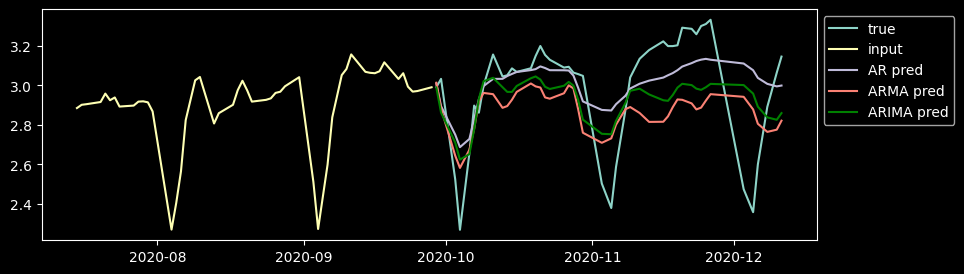

In [48]:
fig, axes = plt.subplots(1,1, figsize=(10,3))
axes.plot(t_test, x_test, label='true')
axes.plot(t_train[100:], x_train[100:], label='input')
axes.plot(t_test, x_pred_ar, label='AR pred')
axes.plot(t_test, x_pred_arma, label='ARMA pred')
axes.plot(t_test, x_pred_arima, label='ARIMA pred', color='green')
axes.legend(bbox_to_anchor=(1,1))
plt.show()

In [49]:
print('AR: {:.3f}\nARMA: {:.3f}\nARIMA: {:.3f}'.format(mean_squared_error(x_test, x_pred_ar),
                                               mean_squared_error(x_test, x_pred_arma),
                                               mean_squared_error(x_test, x_pred_arima)))

AR: 0.049
ARMA: 0.067
ARIMA: 0.053
